<a href="https://colab.research.google.com/github/magnusbrigido/ClassroomProject/blob/main/lab_1_iteracao_de_valor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experimento 1: Iteração de valor

In [20]:
# Importações
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns

In [21]:
# Ambiente: Navegação no Labirinto (gridworld)

class AmbienteNavegacaoLabirinto:
    def __init__(self, world_size, bad_states, target_states, allow_bad_entry=False, rewards=[-1, -1, 1, 0]):
        """
        Inicializa o ambiente de navegação em labirinto.

        Parâmetros:
        - world_size: tupla (n_linhas, n_colunas)
        - bad_states: lista de tuplas com coordenadas de estados penalizados
        - target_states: lista de tuplas com coordenadas dos estados de objetivo
        - allow_bad_entry: bool, se False impede entrada em estados ruins (rebote)
        - rewards: lista de recompensas com [r_boundary, r_bad, r_target, r_other]
        """
        self.n_rows, self.n_cols = world_size   # dimensões da grade do labirinto
        self.bad_states = set(bad_states)       # estados com penalidade alta
        self.target_states = set(target_states) # estados com recompensa alta
        self.allow_bad_entry = allow_bad_entry  # se o agente pode entrar em estados ruins

        # Recompensas definidas para cada tipo de transição
        self.r_boundary = rewards[0]  # tentar sair da grade
        self.r_bad = rewards[1]       # transição para estado ruim
        self.r_target = rewards[2]    # transição para estado alvo
        self.r_other = rewards[3]     # demais transições

        # Espaço de ações: dicionário com deslocamentos (linha, coluna)
        self.action_space = {
            0: (-1, 0),  # cima
            1: (1, 0),   # baixo
            2: (0, -1),  # esquerda
            3: (0, 1),   # direita
            4: (0, 0)    # permanecer no mesmo estado
        }

        # Espaço de recompensas: lista de recompensas possíveis
        self.recompensas_possiveis = np.array(sorted(set(rewards)))
        self.reward_map = {r: i for i, r in enumerate(self.recompensas_possiveis)}

        # número total de estados
        self.n_states = self.n_rows * self.n_cols

        # número total de ações
        self.n_actions = len(self.action_space)

        # número total de recompensas possíveis
        self.n_rewards = self.recompensas_possiveis.shape[0]

        # Tensor de probabilidades de transição: P(s'|s,a)
        self.state_transition_probabilities = np.zeros((self.n_states, self.n_states, self.n_actions))

        # Tensor de probabilidade de recompensas: P(r|s,a)
        self.reward_probabilities = np.zeros((self.n_rewards, self.n_states, self.n_actions))

        # Matriz de recompensa imediata
        self.recompensas_imediatas = np.zeros((self.n_states, self.n_actions))

        self.agent_pos = (0, 0)  # posição inicial do agente

        self._init_dynamics()  # inicializa as dinâmicas de transição e recompensa


    def _init_dynamics(self):
        """
        Preenche as matrizes de transição e recompensa com base
        na estrutura do ambiente e regras de movimentação.
        """
        for indice_estado in range(self.n_states):
            estado_atual = self.index_to_state(indice_estado)

            for acao, (d_linha, d_coluna) in self.action_space.items():
                proxima_posicao = (estado_atual[0] + d_linha, estado_atual[1] + d_coluna)

                # Verifica se o movimento é válido ou resulta em rebote
                if not self._in_bounds(proxima_posicao) or (not self.allow_bad_entry and proxima_posicao in self.bad_states):
                    proximo_estado = estado_atual  # rebote: permanece no estado atual
                else:
                    proximo_estado = proxima_posicao

                # Calcula a recompensa imediata da transição (s, a)
                recompensa = self._compute_reward(proxima_posicao)

                # Armazena a recompensa imediata na matriz
                self.recompensas_imediatas[indice_estado, acao] = recompensa

                # Ambiente determinístico
                indice_proximo = self.state_to_index(proximo_estado)
                self.state_transition_probabilities[indice_proximo, indice_estado, acao] = 1.0  # registra probabilidade P(s'|s,a)
                indice_recompensa = self.reward_map[recompensa]
                self.reward_probabilities[indice_recompensa, indice_estado, acao] = 1.0  # registra probabilidade P(r|s,a)


    def reset(self):
        """Reinicia a posição do agente para o estado inicial (0, 0)."""
        self.agent_pos = (0, 0)
        return self.agent_pos


    def step(self, acao):
        """
        Executa uma ação no ambiente e atualiza a posição do agente.

        Parâmetros:
        - acao: índice da ação a ser executada (0 a 4)

        Retorna:
        - nova posição do agente (linha, coluna)
        - recompensa recebida
        """
        d_linha, d_coluna = self.action_space[acao]
        linha_destino = self.agent_pos[0] + d_linha
        coluna_destino = self.agent_pos[1] + d_coluna
        destino = (linha_destino, coluna_destino)

        # Se movimento for inválido ou entrada proibida, permanece
        if not self._in_bounds(destino) or (not self.allow_bad_entry and destino in self.bad_states):
            destino = self.agent_pos

        recompensa = self._compute_reward(destino)
        self.agent_pos = destino
        return self.agent_pos, recompensa


    def _in_bounds(self, posicao):
        """Verifica se uma posição está dentro dos limites do labirinto."""
        linha, coluna = posicao
        return 0 <= linha < self.n_rows and 0 <= coluna < self.n_cols


    def _compute_reward(self, destino):
        """
        Define a recompensa com base no destino proposto:
        - r_boundary: fora do grid
        - r_bad: célula ruim
        - r_target: célula alvo
        - r_other: demais casos
        """
        if not self._in_bounds(destino):
            return self.r_boundary
        elif destino in self.bad_states:
            return self.r_bad
        elif destino in self.target_states:
            return self.r_target
        else:
            return self.r_other


    def state_to_index(self, estado):
        """Converte coordenada (linha, coluna) para índice linear."""
        linha, coluna = estado
        return linha * self.n_cols + coluna


    def index_to_state(self, indice):
        """Converte índice linear para coordenada (linha, coluna)."""
        return divmod(indice, self.n_cols)  # (linha, coluna) = (indice // self.n_cols, indice % self.n_cols)

In [22]:
# Funções auxiliares para visualização

def plot_policy(env, policy, ax=None):
    fig, ax = _prepare_grid(env, ax=ax)

    for (r, c), action in policy.items():
        x, y = c + 0.5, r + 0.5
        color = 'black'
        lw = 1.5

        if action == 0:
            ax.arrow(x, y, dx=0, dy=-0.3, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 1:
            ax.arrow(x, y, dx=0, dy=0.3, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 2:
            ax.arrow(x, y, dx=-0.3, dy=0, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 3:
            ax.arrow(x, y, dx=0.3, dy=0, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 4:
            circ = patches.Circle((x, y), 0.1, edgecolor=color, facecolor='none', linewidth=lw)
            ax.add_patch(circ)

    ax.set_title("Política")
    plt.show()

    return

def _prepare_grid(env, ax=None, draw_cells=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(env.n_cols, env.n_rows))
    ax.set_xlim(0, env.n_cols)
    ax.set_ylim(0, env.n_rows)
    ax.set_xticks(np.arange(0, env.n_cols + 1, 1))
    ax.set_yticks(np.arange(0, env.n_rows + 1, 1))
    ax.grid(True)
    ax.set_aspect('equal')
    ax.invert_yaxis()

    if draw_cells:
        for r in range(env.n_rows):
            for c in range(env.n_cols):
                cell = (r, c)
                if cell in env.bad_states:
                    color = 'red'
                elif cell in env.target_states:
                    color = 'green'
                else:
                    color = 'white'
                rect = patches.Rectangle(xy=(c, r), width=1, height=1, facecolor=color, edgecolor='gray')
                ax.add_patch(rect)

    return (None, ax) if ax else (fig, ax)


def plot_valores_de_estado(valores_estado, ambiente):
    plt.figure(figsize=(ambiente.n_rows, ambiente.n_cols))
    ax = sns.heatmap(
        data=valores_estado.reshape(ambiente.n_rows, ambiente.n_cols),
        annot=True,
        fmt='.1f',
        cmap='bwr',
        square=True,
        cbar=True,
        linewidths=0.5,
        linecolor='gray',
    )
    ax.set_title(r"Valores de Estado (V(s))")
    plt.tight_layout()
    plt.show()


def plot_valores_de_acao(valores_de_acao):
    Q_transposta = valores_de_acao.T
    n_acoes, n_estados = Q_transposta.shape

    plt.figure(figsize=(n_estados, n_acoes))
    ax = sns.heatmap(
        Q_transposta,
        annot=True,
        fmt='.1f',
        cmap='bwr',
        cbar=True,
        square=False,
        linewidths=0.5,
        linecolor='gray'
    )
    # Rótulos das colunas (estados)
    ax.set_xticks(np.arange(n_estados) + 0.5)
    ax.set_xticklabels([f"s{i}" for i in range(n_estados)], rotation=0)

    # Rótulos das linhas (ações)
    ax.set_yticks(np.arange(n_acoes) + 0.5)
    ax.set_yticklabels([f"a{i}" for i in range(n_acoes)], rotation=0)

    ax.set_xlabel(r"Estados")
    ax.set_ylabel(r"Ações")
    ax.set_title(r"Valores de ação (Q(s, a) transposta)")
    plt.tight_layout()
    plt.show()


def plot_labirinto(ambiente):
    """
    Visualiza o labirinto usando seaborn.heatmap sem ticks nos eixos.

    Representa:
    - Estado neutro: branco
    - Estado ruim: vermelho
    - Estado alvo: verde
    """
    # Cria matriz com valores padrão (0 = neutro)
    matriz = np.zeros((ambiente.n_rows, ambiente.n_cols), dtype=int)

    # Marca os estados ruins como 1
    for (r, c) in ambiente.bad_states:
        matriz[r, c] = 1

    # Marca os estados alvo como 2
    for (r, c) in ambiente.target_states:
        matriz[r, c] = 2

    # Mapa de cores: branco = neutro, vermelho = ruim, verde = alvo
    cmap = ListedColormap(["white", "red", "green"])

    plt.figure(figsize=(ambiente.n_cols, ambiente.n_rows))
    ax = sns.heatmap(
        matriz,
        cmap=cmap,
        cbar=False,
        linewidths=0.5,
        linecolor='gray',
        square=True
    )

    # Remove todos os ticks e labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ax.set_title("Visualização do Labirinto")
    plt.tight_layout()
    plt.show()

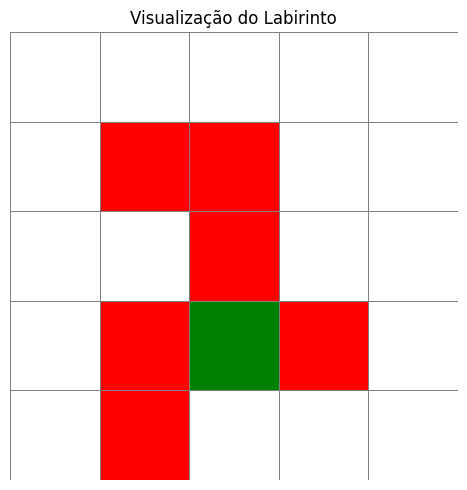

In [23]:
ambiente = AmbienteNavegacaoLabirinto(
        world_size=(5, 5),
        bad_states=[(1, 1), (1, 2), (2, 2), (3, 1), (3, 3), (4, 1)],
        target_states=[(3, 2)],
        allow_bad_entry=True,
        rewards=[-1, -10, 1, 0]
    )
plot_labirinto(ambiente)

In [24]:
def iteracao_de_valor(ambiente, gamma=0.9, theta=1e-6, max_iteracoes=1000):
    """
    Implementa o algoritmo de Iteração de Valor para encontrar a política ótima.

    Parâmetros:
    - ambiente: instância da classe AmbienteNavegacaoLabirinto
    - gamma: fator de desconto (0 < gamma <= 1)
    - theta: limiar mínimo de variação para considerar convergência
    - max_iteracoes: número máximo de iterações permitidas

    Retorna:
    - vetor de valores de estado V (numpy array) para todos os estados
    - matriz de valores de ação Q (numpy array) para todos os pares (estado, ação)
    - política ótima (dicionário de estado para ação)
    """

    # Informações úteis do ambiente:
    # número de estados: ambiente.n_states
    # número de ações: ambiente.n_actions
    # número de recompensas (únicas): ambiente.n_rewards
    # Tensor de probabilidade de recompensas: P(r|s,a): ambiente.reward_probabilities shape=(ambiente.n_rewards, ambiente.n_states, ambiente.n_actions)
    # recompensas: ambiente.recompensas_possiveis (ambiente.recompensas_possiveis[i] com probabilidade ambiente.reward_probabilities[i,s,a])
    # Tensor de probabilidades de transição: P(s'|s,a): ambiente.state_transition_probabilities shape=(ambiente.n_states, ambiente.n_states, ambiente.n_actions)


    ######################################################################################
    # Código da iteração de valor aqui

    V = np.zeros(ambiente.n_states)

    for i in range(max_iteracoes):
        delta = 0
        V_novo = np.copy(V)

        for s in range(ambiente.n_states):
            valores_acao = []

            for a in range(ambiente.n_actions):
                valor_esperado = 0.0

                # Soma sobre todas as recompensas possíveis
                for r_idx in range(ambiente.n_rewards):
                    r = ambiente.recompensas_possiveis[r_idx]
                    p_r = ambiente.reward_probabilities[r_idx, s, a]

                    # Soma sobre todos os estados possíveis
                    for s_prime in range(ambiente.n_states):
                        p_s = ambiente.state_transition_probabilities[s_prime, s, a]
                        valor_esperado += p_r * p_s * (r + gamma * V[s_prime])

                valores_acao.append(valor_esperado)

            V_novo[s] = max(valores_acao)
            delta = max(delta, abs(V_novo[s] - V[s]))

        V = V_novo

        if delta < theta:
            break

    # Calcula matriz de valores de ação Q(s,a)
    Q = np.zeros((ambiente.n_states, ambiente.n_actions))

    for s in range(ambiente.n_states):
        for a in range(ambiente.n_actions):
            valor_esperado = 0.0
            for r_idx in range(ambiente.n_rewards):
                r = ambiente.recompensas_possiveis[r_idx]
                p_r = ambiente.reward_probabilities[r_idx, s, a]

                for s_prime in range(ambiente.n_states):
                    p_s = ambiente.state_transition_probabilities[s_prime, s, a]
                    valor_esperado += p_r * p_s * (r + gamma * V[s_prime])

            Q[s, a] = valor_esperado

    # Define a política ótima
    politica_otima = {}
    for s in range(ambiente.n_states):
        melhor_acao = np.argmax(Q[s])
        coord_estado = ambiente.index_to_state(s)
        politica_otima[coord_estado] = melhor_acao

    # Deve calcular:
    # Valores de estado V (numpy array) para todos os estados (shape = (ambiente.n_states, ))
    # Valores de ação Q (numpy array) para todos os estados (shape = (ambiente.n_states, ambiente.n_actions))
    # política ótima como dicionário {estado - tupla: melhor_acao - int 0 a 4} (dica: usar ambiente.index_to_state(estado))


    ######################################################################################

    return V, Q, politica_otima, i

V:  [3.48677619 3.87419668 4.30466389 4.78296079 5.31440179 3.13809775
 3.48677619 4.78296079 5.31440179 5.90489179 2.82428716 2.54185762
 9.99999179 5.90489179 6.56099179 2.54185762 9.99999179 9.99999179
 9.99999179 7.28999179 2.28767104 8.99999179 9.99999179 8.99999179
 8.09999179] 
Q:  [[ 2.13809857  2.82428798  2.13809857  3.48677701  3.13809857]
 [ 2.48677701 -6.86190143  3.13809857  3.8741975   3.48677701]
 [ 2.8741975  -5.69533529  3.48677701  4.30466471  3.8741975 ]
 [ 3.30466471  4.78296161  3.8741975   4.78296161  4.30466471]
 [ 3.78296161  5.31440261  4.30466471  3.78296161  4.78296161]
 [ 3.13809857  2.54185844  1.82428798 -6.86190143  2.82428798]
 [ 3.48677701  2.28767186  2.82428798 -5.69533529 -6.86190143]
 [ 3.8741975  -1.00000739 -6.86190143  4.78296161 -5.69533529]
 [ 4.30466471  5.31440261 -5.69533529  5.31440261  4.78296161]
 [ 4.78296161  5.90489261  4.78296161  4.31440261  5.31440261]
 [ 2.82428798  2.28767186  1.54185844  2.28767186  2.54185844]
 [-6.86190143 -1.

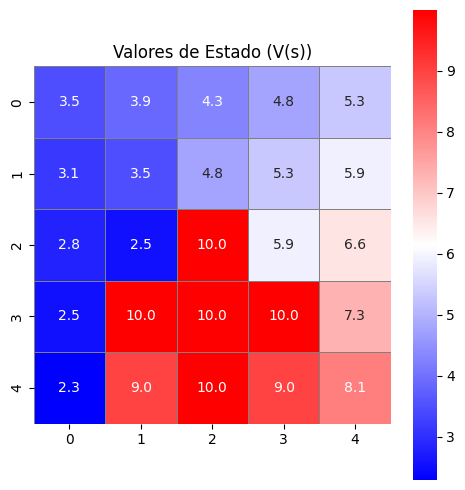

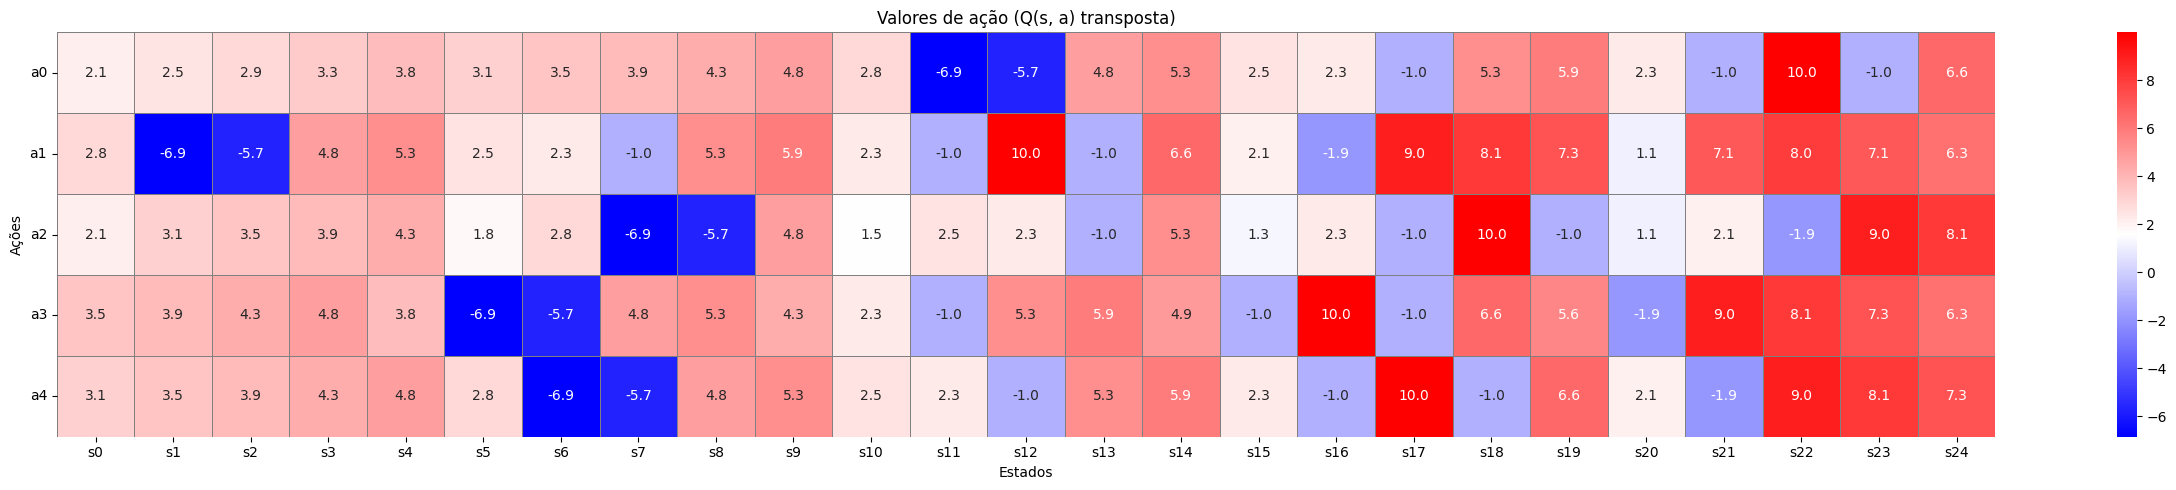

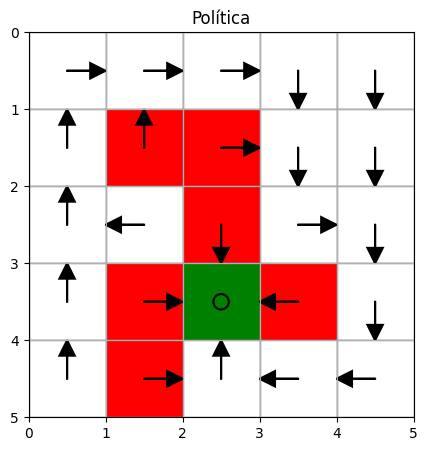

In [25]:
V, Q, politica, i = iteracao_de_valor(ambiente, gamma=0.9, theta=1e-6, max_iteracoes=1000)
print('V: ', V, '\nQ: ', Q, '\npolitica: ', politica)
plot_valores_de_estado(V, ambiente)

plot_valores_de_acao(Q)

plot_policy(ambiente, politica)

# Tarefa:

1. Observar e reportar o efeito de diferentes valores da taxa de desconto (por exemplo: gamma = 0, 0.5 e 0.9)
2. Observar e reportar o efeito r_bad = -1 ao invés de -10
3. Observar e reportar o efeito de uma transformação afim em todas as recompensas, isto é,
[r_boundary, r_bad, r_target, r_other] = [-1, -10, 1, 0] -> a * [-1, -10, 1, 0] + b para todo r

Entregar o PDF do notebook no colab (código + relatório em markdown)

### 1. Observar e reportar o efeito de diferentes valores da taxa de desconto (por exemplo: gamma = 0, 0.5 e 0.9)

V:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0.
 0.] 
Q:  [[ -1.   0.  -1.   0.   0.]
 [ -1. -10.   0.   0.   0.]
 [ -1. -10.   0.   0.   0.]
 [ -1.   0.   0.   0.   0.]
 [ -1.   0.   0.  -1.   0.]
 [  0.   0.  -1. -10.   0.]
 [  0.   0.   0. -10. -10.]
 [  0. -10. -10.   0. -10.]
 [  0.   0. -10.   0.   0.]
 [  0.   0.   0.  -1.   0.]
 [  0.   0.  -1.   0.   0.]
 [-10. -10.   0. -10.   0.]
 [-10.   1.   0.   0. -10.]
 [  0. -10. -10.   0.   0.]
 [  0.   0.   0.  -1.   0.]
 [  0.   0.  -1. -10.   0.]
 [  0. -10.   0.   1. -10.]
 [-10.   0. -10. -10.   1.]
 [  0.   0.   1.   0. -10.]
 [  0.   0. -10.  -1.   0.]
 [  0.  -1.  -1. -10.   0.]
 [-10.  -1.   0.   0. -10.]
 [  1.  -1. -10.   0.   0.]
 [-10.  -1.   0.   0.   0.]
 [  0.  -1.   0.  -1.   0.]] 
politica:  {(0, 0): np.int64(1), (0, 1): np.int64(2), (0, 2): np.int64(2), (0, 3): np.int64(1), (0, 4): np.int64(1), (1, 0): np.int64(0), (1, 1): np.int64(0), (1, 2): np.int64(0), (1, 3): np.int64(0), (1, 4): np

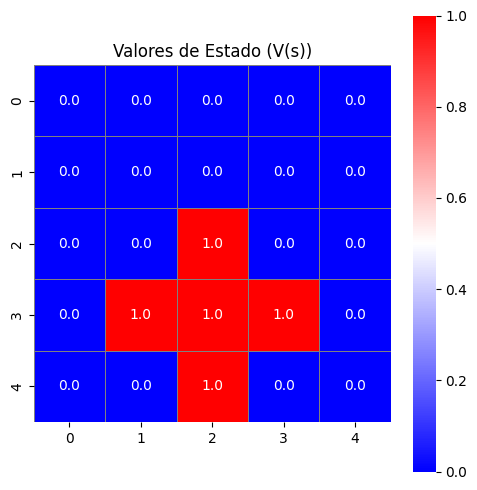

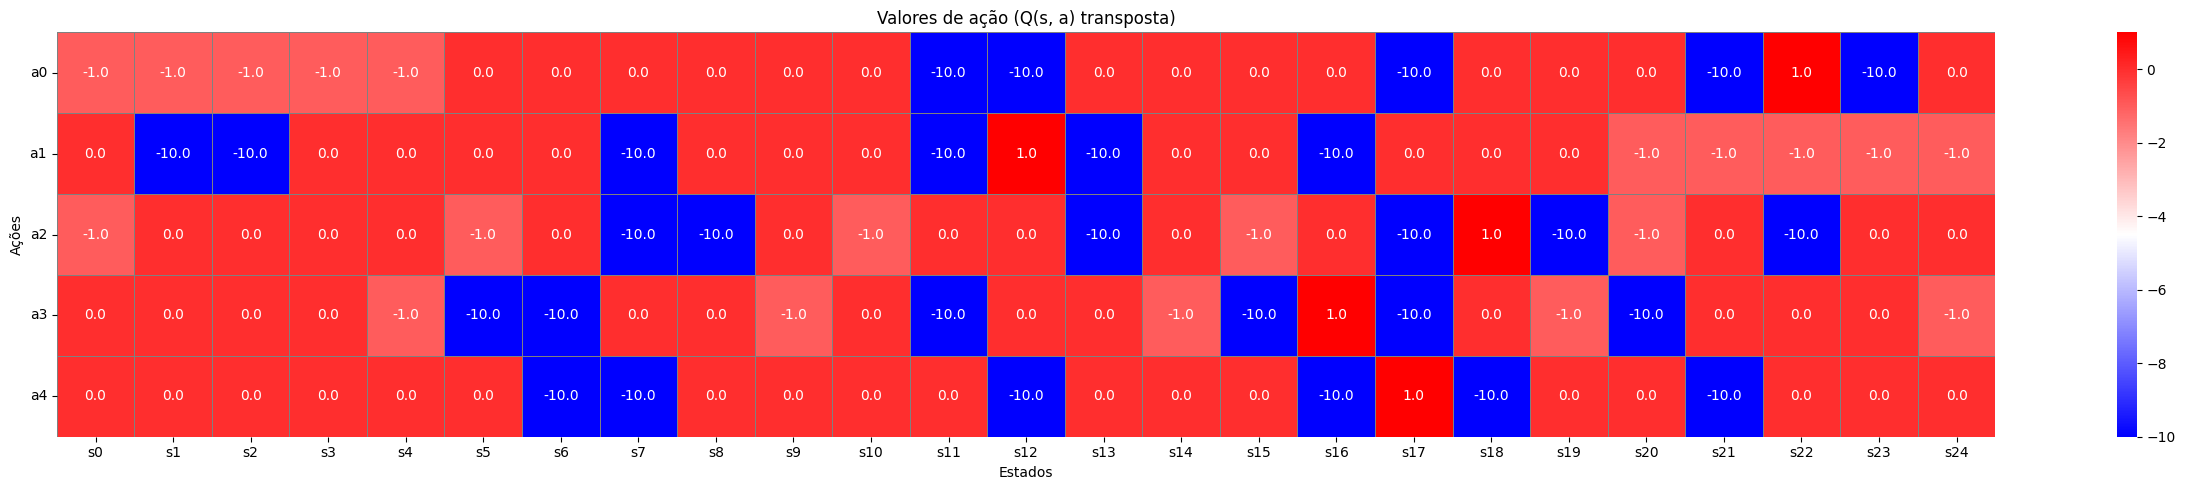

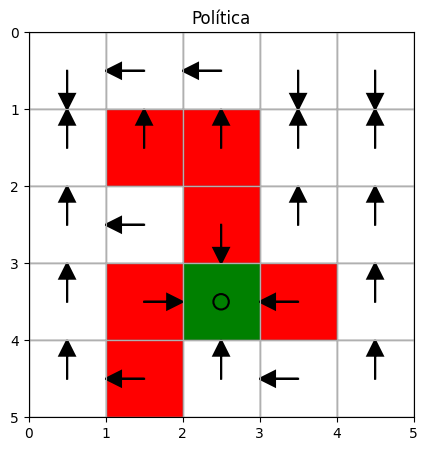

V:  [1.95217133e-03 3.90529633e-03 7.81154633e-03 1.56240463e-02
 3.12490463e-02 9.75608826e-04 1.95217133e-03 1.56240463e-02
 3.12490463e-02 6.24990463e-02 4.87327576e-04 2.43186951e-04
 1.99999905e+00 6.24990463e-02 1.24999046e-01 2.43186951e-04
 1.99999905e+00 1.99999905e+00 1.99999905e+00 2.49999046e-01
 1.21116638e-04 9.99999046e-01 1.99999905e+00 9.99999046e-01
 4.99999046e-01] 
Q:  [[-9.99023914e-01  4.87804413e-04 -9.99023914e-01  1.95264816e-03
   9.76085663e-04]
 [-9.98047352e-01 -9.99902391e+00  9.76085663e-04  3.90577316e-03
   1.95264816e-03]
 [-9.96094227e-01 -9.99218798e+00  1.95264816e-03  7.81202316e-03
   3.90577316e-03]
 [-9.92187977e-01  1.56245232e-02  3.90577316e-03  1.56245232e-02
   7.81202316e-03]
 [-9.84375477e-01  3.12495232e-02  7.81202316e-03 -9.84375477e-01
   1.56245232e-02]
 [ 9.76085663e-04  2.43663788e-04 -9.99512196e-01 -9.99902391e+00
   4.87804413e-04]
 [ 1.95264816e-03  1.21593475e-04  4.87804413e-04 -9.99218798e+00
  -9.99902391e+00]
 [ 3.90577316

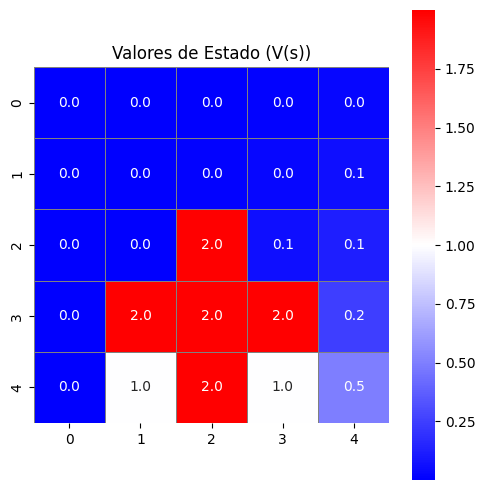

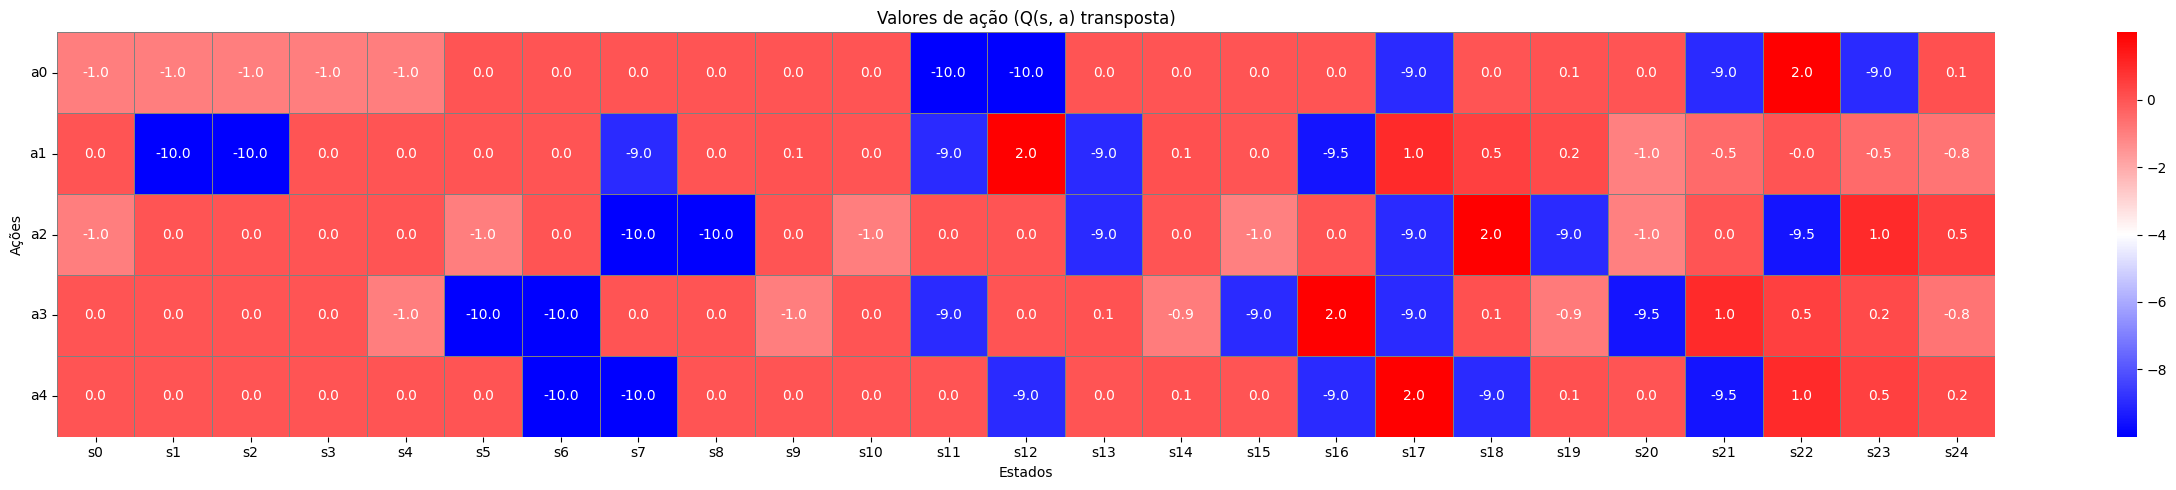

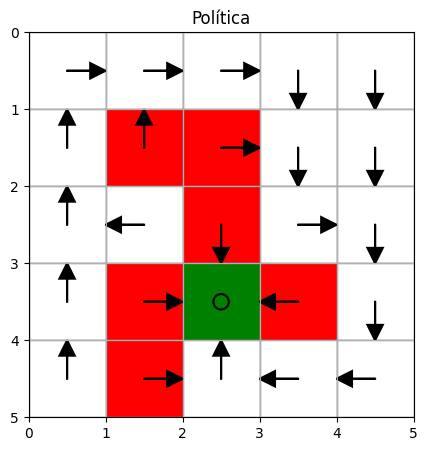

V:  [3.48677619 3.87419668 4.30466389 4.78296079 5.31440179 3.13809775
 3.48677619 4.78296079 5.31440179 5.90489179 2.82428716 2.54185762
 9.99999179 5.90489179 6.56099179 2.54185762 9.99999179 9.99999179
 9.99999179 7.28999179 2.28767104 8.99999179 9.99999179 8.99999179
 8.09999179] 
Q:  [[ 2.13809857  2.82428798  2.13809857  3.48677701  3.13809857]
 [ 2.48677701 -6.86190143  3.13809857  3.8741975   3.48677701]
 [ 2.8741975  -5.69533529  3.48677701  4.30466471  3.8741975 ]
 [ 3.30466471  4.78296161  3.8741975   4.78296161  4.30466471]
 [ 3.78296161  5.31440261  4.30466471  3.78296161  4.78296161]
 [ 3.13809857  2.54185844  1.82428798 -6.86190143  2.82428798]
 [ 3.48677701  2.28767186  2.82428798 -5.69533529 -6.86190143]
 [ 3.8741975  -1.00000739 -6.86190143  4.78296161 -5.69533529]
 [ 4.30466471  5.31440261 -5.69533529  5.31440261  4.78296161]
 [ 4.78296161  5.90489261  4.78296161  4.31440261  5.31440261]
 [ 2.82428798  2.28767186  1.54185844  2.28767186  2.54185844]
 [-6.86190143 -1.

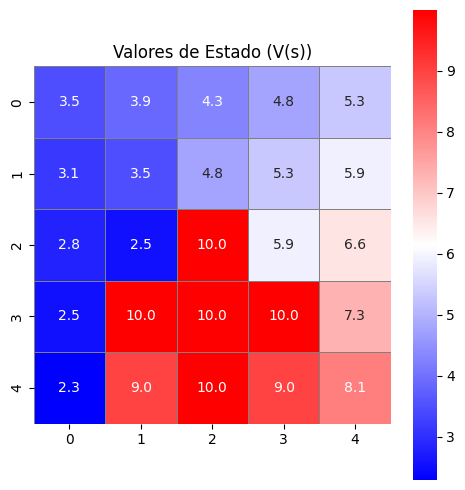

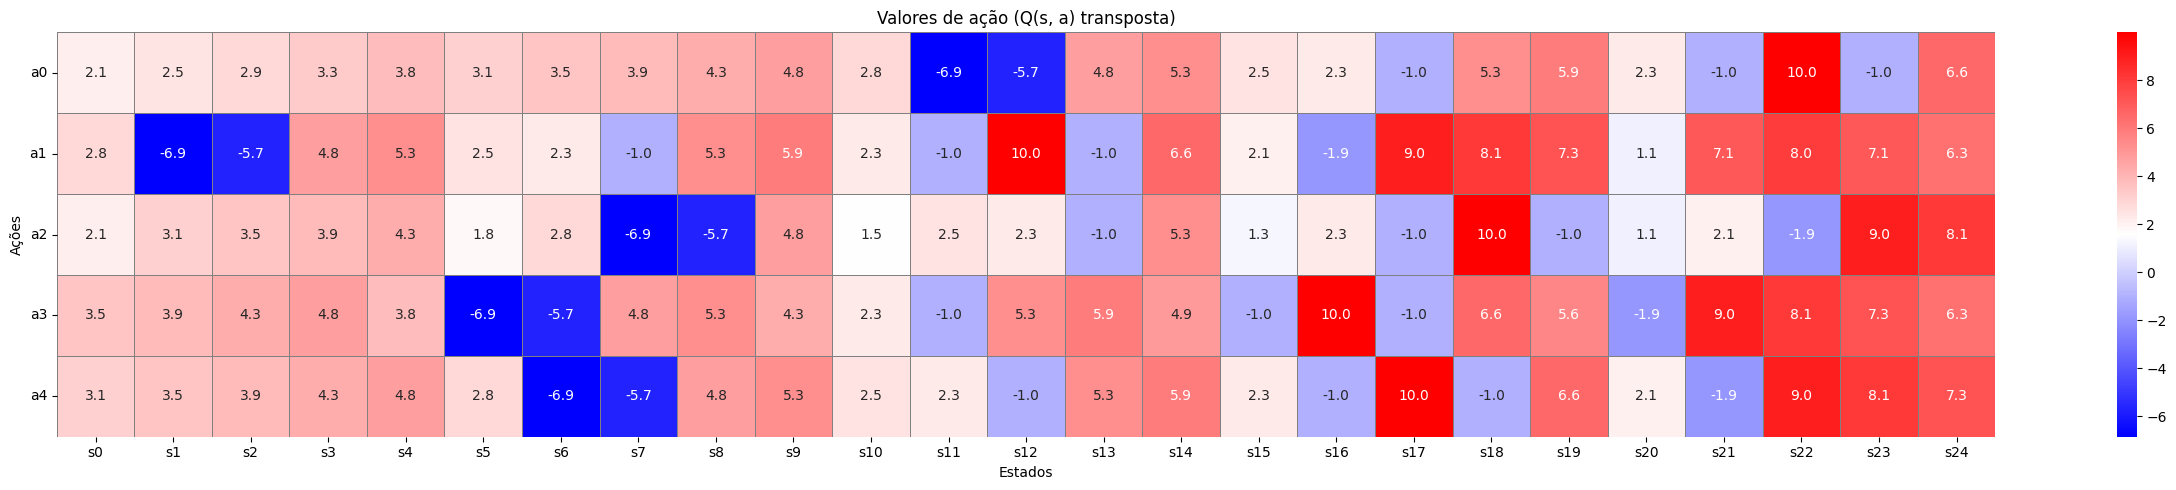

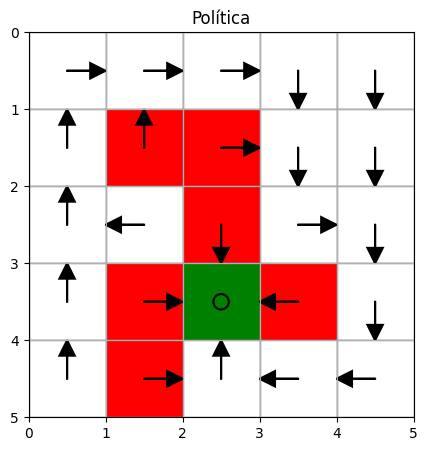

In [26]:
ambiente = AmbienteNavegacaoLabirinto(
        world_size=(5, 5),
        bad_states=[(1, 1), (1, 2), (2, 2), (3, 1), (3, 3), (4, 1)],
        target_states=[(3, 2)],
        allow_bad_entry=True,
        rewards=[-1, -10, 1, 0]
    )

desconto = [0, 0.5, 0.9]

for i in range(3):
  V, Q, politica, i = iteracao_de_valor(ambiente, gamma=desconto[i], theta=1e-6, max_iteracoes=1000)
  print('V: ', V, '\nQ: ', Q, '\npolitica: ', politica)
  plot_valores_de_estado(V, ambiente)

  plot_valores_de_acao(Q)

  plot_policy(ambiente, politica)

* #### Taxa de desconto = 0.0:
##### O agente prioriza apenas as recompensas imediatas, o agente, neste caso, está seguindo a ordem cima, baixo, esquerda, direita e permanecer. O que fica aparente que na política gerada todos os estados que não transitam para o estado alvo, que possui recompensa imediata igual à 1, seguem a sequência de ação, alterando a ação para uma seguinte quando a atual gera uma punição. Sendo assim, vimos que os estados que geram as melhores trajetórias para alvo são os que têm transição direta para ele.

* #### Taxa de desconto = 0.5:
##### Utilizando esta taxa, temos uma maior consideração por recompensas futuras que o exemplo anterior, já produzindo uma política ótima para esta situação.

* #### Taxa de desconto = 0.9:
##### Esta taxa máxima, para manter o retorno finito, produz a mesma política que a taxa à 0.5, porém com maior variação nos valores de estado e de ação, tornando possíveis estados transacionais com valor mais significativo em relação ao exemplo anterior.

### 2. Observar e reportar o efeito r_bad = -1 ao invés de -10

V:  [5.83199179 5.57999179 6.19999179 6.47999179 5.83199179 6.47999179
 7.19999179 7.99999179 7.19999179 6.47999179 7.19999179 7.99999179
 9.99999179 7.99999179 7.19999179 7.99999179 9.99999179 9.99999179
 9.99999179 7.99999179 7.19999179 8.99999179 9.99999179 8.99999179
 8.09999179] 
Q:  [[4.24879261 5.83199261 4.24879261 5.02199261 5.24879261]
 [4.02199261 5.47999261 5.24879261 5.57999261 5.02199261]
 [4.57999261 6.19999261 5.02199261 5.83199261 5.57999261]
 [4.83199261 6.47999261 5.57999261 5.24879261 5.83199261]
 [4.24879261 5.83199261 5.83199261 4.24879261 5.24879261]
 [5.24879261 6.47999261 4.83199261 5.47999261 5.83199261]
 [5.02199261 7.19999261 5.83199261 6.19999261 5.47999261]
 [5.57999261 7.99999261 5.47999261 6.47999261 6.19999261]
 [5.83199261 7.19999261 6.19999261 5.83199261 6.47999261]
 [5.24879261 6.47999261 6.47999261 4.83199261 5.83199261]
 [5.83199261 7.19999261 5.47999261 7.19999261 6.47999261]
 [5.47999261 7.99999261 6.47999261 7.99999261 7.19999261]
 [6.19999261 9

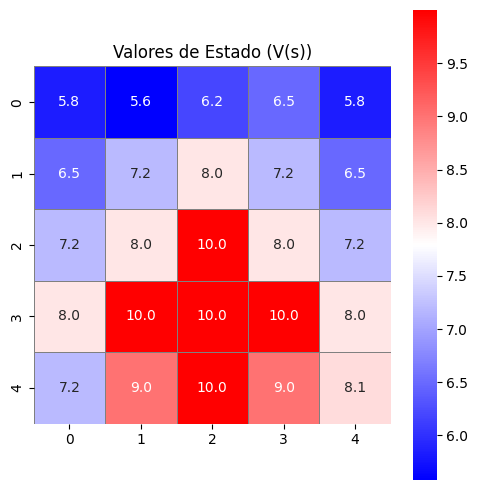

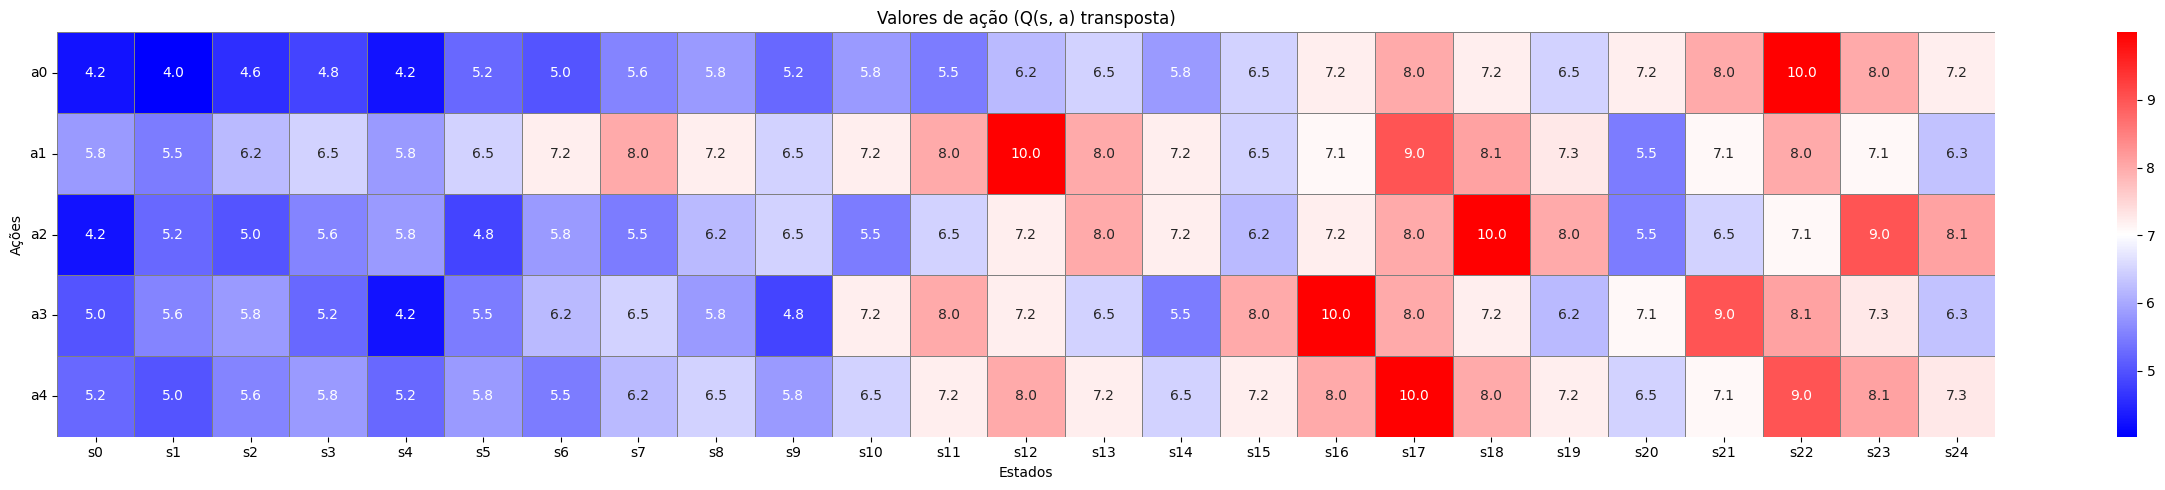

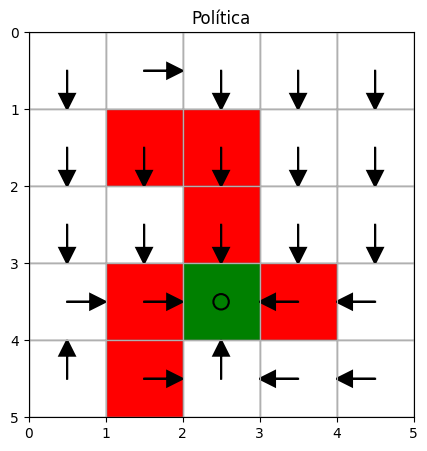

In [27]:
ambiente = AmbienteNavegacaoLabirinto(
        world_size=(5, 5),
        bad_states=[(1, 1), (1, 2), (2, 2), (3, 1), (3, 3), (4, 1)],
        target_states=[(3, 2)],
        allow_bad_entry=True,
        rewards=[-1, -1, 1, 0]
    )

V, Q, politica, i = iteracao_de_valor(ambiente, gamma=0.9, theta=1e-6, max_iteracoes=1000)
print('V: ', V, '\nQ: ', Q, '\npolitica: ', politica)
plot_valores_de_estado(V, ambiente)

plot_valores_de_acao(Q)

plot_policy(ambiente, politica)

##### Ao executar o código acima com o valor de r_bad alterado para -1, o agente não considera que passar por estados ruins seja um preço grande a se pagar, compensando atravessá-los para chegar mais rapidamente ao alvo.

### 3. Observar e reportar o efeito de uma transformação afim em todas as recompensas, isto é, [r_boundary, r_bad, r_target, r_other] = [-1, -10, 1, 0] -> a * [-1, -10, 1, 0] + b para todo r

V:  [56.97356018 57.74840116 58.60933558 59.56592938 60.62881138 56.2762033
 56.97356018 59.56592938 60.62881138 61.80979138 55.64858211 55.08372303
 69.99999138 61.80979138 63.12199138 55.08372303 69.99999138 69.99999138
 69.99999138 64.57999138 54.57534987 67.99999138 69.99999138 67.99999138
 66.19999138] 
Q:  [[54.27620416 55.64858297 54.27620416 56.97356104 56.27620416]
 [54.97356104 36.27620416 56.27620416 57.74840202 56.97356104]
 [55.74840202 38.60933644 56.97356104 58.60933644 57.74840202]
 [56.60933644 59.56593024 57.74840202 59.56593024 58.60933644]
 [57.56593024 60.62881224 58.60933644 57.56593024 59.56593024]
 [56.27620416 55.08372389 53.64858297 36.27620416 55.64858297]
 [56.97356104 54.57535073 55.64858297 38.60933644 36.27620416]
 [57.74840202 47.99999224 36.27620416 59.56593024 38.60933644]
 [58.60933644 60.62881224 38.60933644 60.62881224 59.56593024]
 [59.56593024 61.80979224 59.56593024 58.62881224 60.62881224]
 [55.64858297 54.57535073 53.08372389 54.57535073 55.083

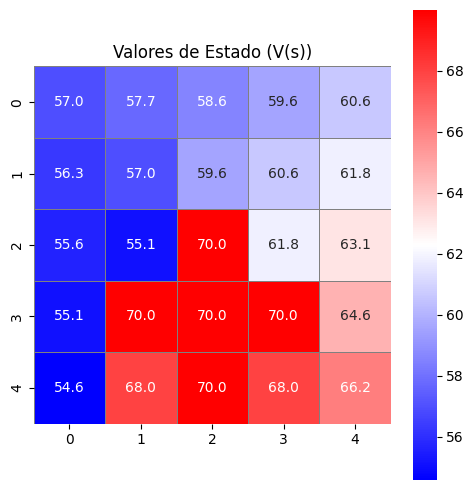

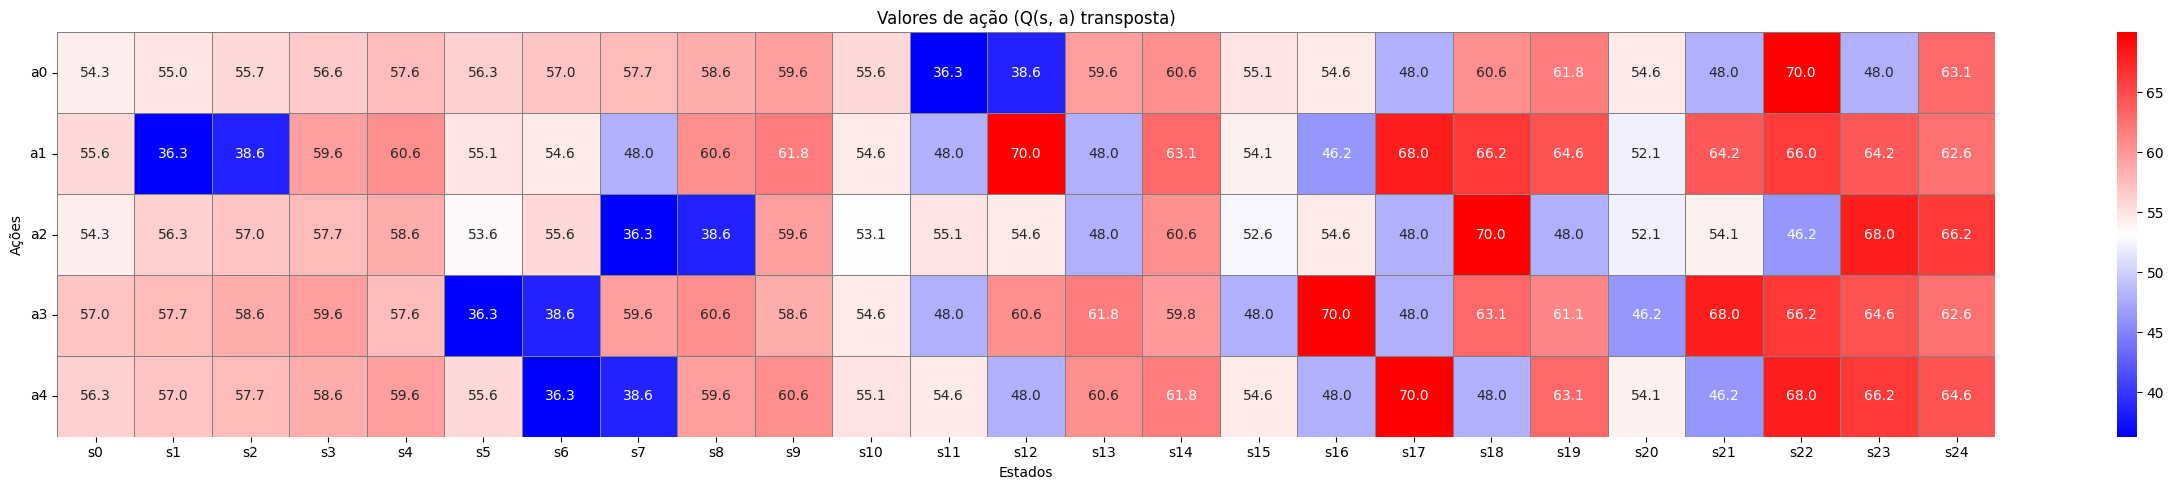

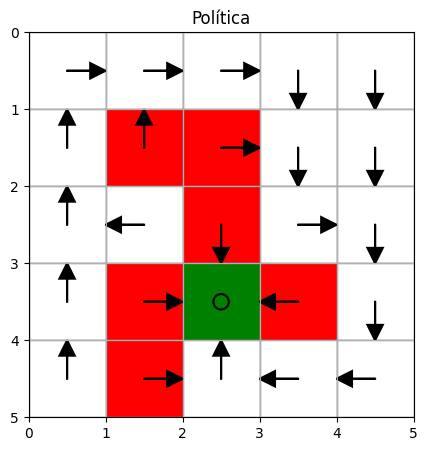

In [28]:
a, b = 2, 5
rewards_transformados = [a*r + b for r in [-1, -10, 1, 0]]

ambiente = AmbienteNavegacaoLabirinto(
        world_size=(5, 5),
        bad_states=[(1, 1), (1, 2), (2, 2), (3, 1), (3, 3), (4, 1)],
        target_states=[(3, 2)],
        allow_bad_entry=True,
        rewards=rewards_transformados
    )

V, Q, politica, i = iteracao_de_valor(ambiente, gamma=0.9, theta=1e-6, max_iteracoes=1000)
print('V: ', V, '\nQ: ', Q, '\npolitica: ', politica)
plot_valores_de_estado(V, ambiente)

plot_valores_de_acao(Q)

plot_policy(ambiente, politica)

##### A política se mantém a mesma por ser invariante à transformação afim, porém os valores de estado são modificados e se tornaram signific

#### Para comparação de interações do experimento 2.

In [29]:
V, Q, politica, i = iteracao_de_valor(ambiente, gamma=0.9, theta=1e-6, max_iteracoes=1000)

print('Convergiu em ', i, ' interações')

Convergiu em  150  interações
